## GraphRNN: A Julia Implementation

In network science, it is usually easy to calculate the properties of a given network,such as its degree distribution, clustering coefficients, or average path length.  On theother  hand,  generating  a  random  network  with  a  well-defined  set  of  properties  hasproven to be no trivial task.  The difficulties stem from the high-dimensional nature,the non-uniqueness of a graph due to isomorphisms, and complex local dependencies(such as different local clustering coefficients).  To address this problem, You et al.  have proposed a new graph generating method in their paper:  “GraphRNN: Generating Realistic Graph with Deep Auto-regressive Model”. 

We re-implemented the GraphRNN model in Julia (with some simplifications). Our
goal is to contribute to the open-source Flux Model Zoo, diversify the available
machine learning model that the Flux library is currently providing. 

In [11]:
using YAML
using Plots

include("graph_visualization.jl")
include("data.jl")
include("graph_generator.jl")
include("train.jl")

sample_sigmoid (generic function with 1 method)

### Dataset Creation

We provide a `graph_generator.jl` model to help create graphs from 4 different graph families. 

1. 2D Grid
2. Ladder
3. Stochastic Block Model
4. Complete Bipartite

In [22]:
sample_graphs = []
graph_type = ["grid", "ladder", "sbm", "complete_bipartite"]
# 1. 2D grid
push!(sample_graphs, grid_graph(15, 5))

# Ladder graph
push!(sample_graphs, Graph(ladder_adj_matrix(15)))

# Stochastic Block Model
push!(sample_graphs, sbm_graph([10 * 0.3 10 * 0.05; 8 * 0.05 8 *0.3], [10, 8]))

# Complete Bipartite
push!(sample_graphs, complete_bipartite_graph(10, 5))

plots = []

for (i, g) in enumerate(sample_graphs)
    push!(plots, graph_viz(g, graph_type[i]))
end

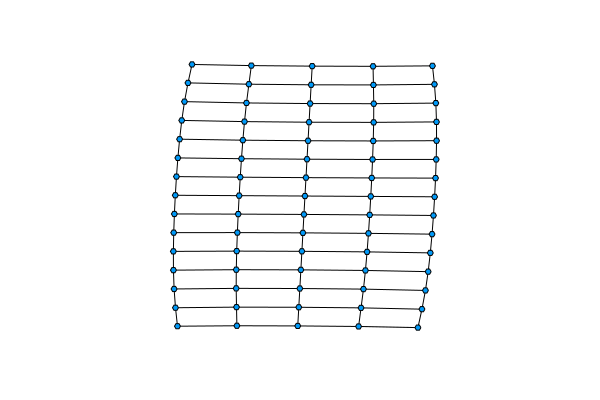

In [23]:
plots[1]

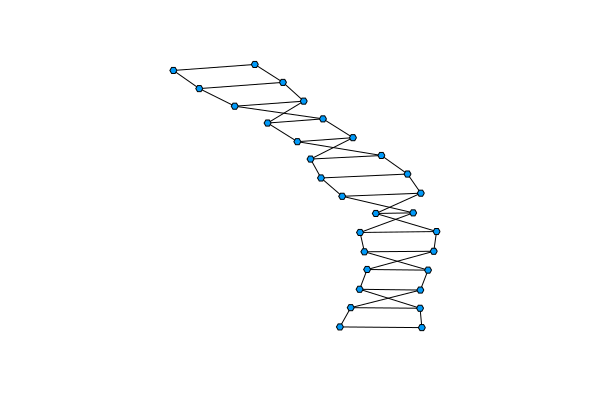

In [24]:
plots[2]

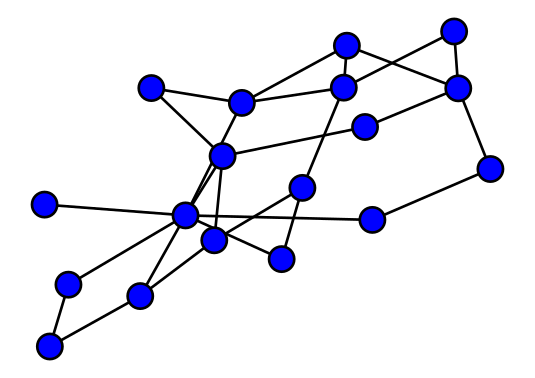

In [25]:
plots[3]

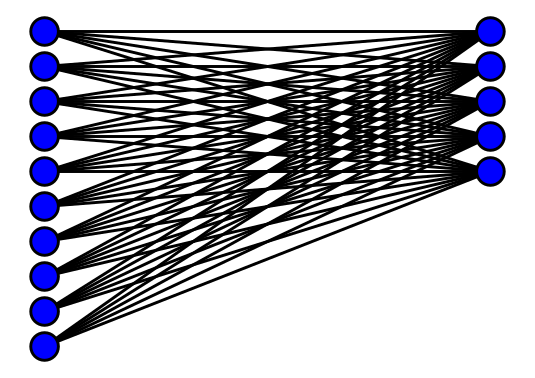

In [26]:
plots[4]

### Create Dataset

Let's create a grid dataset. For this example, we will create a 2D grid dataset with 800 training examples 
and 200 testing examples. 

In [7]:
create_grid_dataset(1000, file_name="grid", max_row=5, min_row=2, max_col=5, min_col=2)

┌ Info: Saving training and testing data... 
└ @ Main /home/tranle/Desktop/GrinnellCollege/FourthYear/Network/FinalProject/GraphRNN/data.jl:69
┌ Info: Done! max_prev_node: 6 	 max_num_node 25 	 num_graphs 1000
└ @ Main /home/tranle/Desktop/GrinnellCollege/FourthYear/Network/FinalProject/GraphRNN/data.jl:75


### Train the Model

We can easily load the dataset and train our model using the function `main(config_path)` provided in the
[train.py](train.py) file. Remember to edit your config yaml file based on the dataset created. 

In the dataset created above, we can see that our `max_prev_node` is 6, and our `max_num_node` is 25. Edit these
parameters in the config yaml file before training. Moreover, provide the path to the training and testing 
dataset under `data/train:` and `data/test:` in the yaml file. 

In [27]:
# Let's take a look at the config file
configs = YAML.load_file("configs/test.yaml")
configs

Dict{Any,Any} with 16 entries:
  "lr"                  => 0.0001
  "node_embedding_size" => 64
  "data"                => Dict{Any,Any}("test"=>"test_grid_data.jld","train"=>…
  "batch_size"          => 2
  "max_prev_node"       => 6
  "node_hidden_size"    => 128
  "node_output_size"    => 16
  "TBlog"               => Dict{Any,Any}("enable"=>true,"img_tag"=>"Test Images…
  "edge_embedding_size" => 8
  "max_num_node"        => 25
  "eval_period"         => 1
  "epochs"              => 30
  "auto_resume"         => Dict{Any,Any}("model_path"=>"","save_model"=>10,"ena…
  "inference"           => Dict{Any,Any}("enable"=>false,"num_preds"=>20)
  "resume_from"         => 1
  "test_batch_size"     => 2

In [28]:
# Now, call main using the path of the config file you want to use to start training the model. 
model = main("configs/test.yaml")

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/tranle/.julia/packages/ProgressMeter/poEzd/src/ProgressMeter.jl:463
Progress: 100%[==================================================] Time: 0:00:12
  iter:  30
  loss:  0.69314784


Training loss at iteration 30: 0.6931465
Testing loss at iteration 30: 0.69314843
Saving model ...


GraphRNN(Flux.cpu, GRUBlock(true, true, Dense(6, 64), Recur(GRUCell(64, 128)), OutputModule(Chain(Dense(128, 64, relu), Dense(64, 16, σ)))), GRUBlock(true, true, Dense(1, 8), Recur(GRUCell(8, 16)), OutputModule(Chain(Dense(16, 8, relu), Dense(8, 1, σ)))))

### Inference

Our function `main(config_path)` return the trained model. We can then use that to make inferences/create graphs. 

In [35]:
# Generate 3 graphs
G_pred = test_rnn_epoch(model, configs["max_num_node"], configs["max_prev_node"]; test_batch_size=3)

3-element Array{Any,1}:
 {26, 135} undirected simple Int64 graph
 {26, 135} undirected simple Int64 graph
 {26, 135} undirected simple Int64 graph

In [36]:
# Since we want to generate 2D grid graphs, use the `grid_viz` function for visualization.
pred_plots = [grid_viz(g) for g in G_pred]

3-element Array{Plots.Plot{Plots.GRBackend},1}:
 Plot{Plots.GRBackend() n=137}
 Plot{Plots.GRBackend() n=137}
 Plot{Plots.GRBackend() n=137}

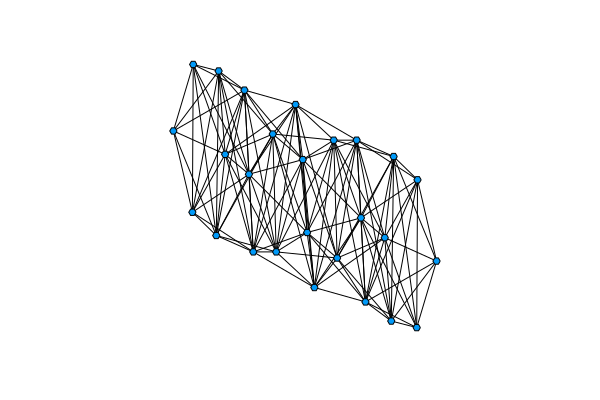

In [37]:
pred_plots[1]

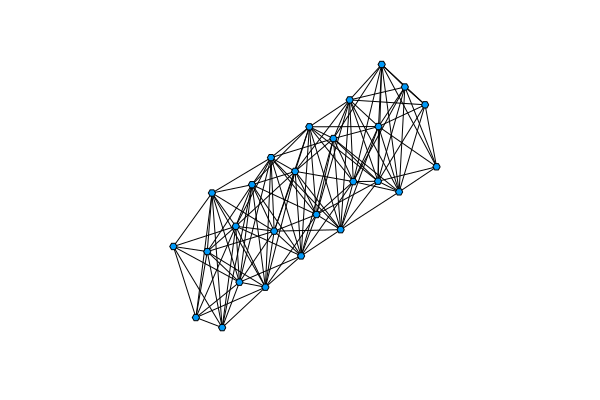

In [38]:
pred_plots[2]

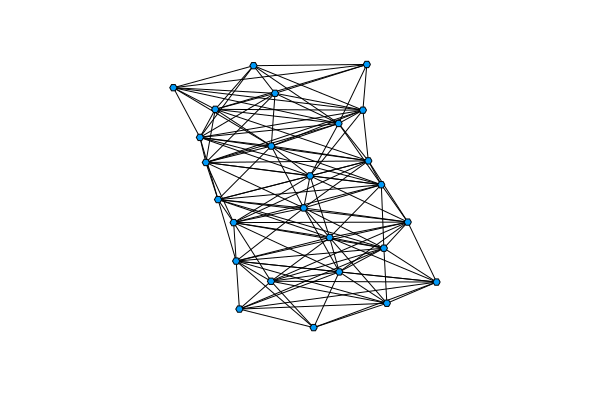

In [39]:
pred_plots[3]

Well! Our dummy trained model does not do a very good job in generating 2D grid graph. But we hope that by playing
with different learning rate, adding more GRU layers to the model, the performance will improve. 

Anyways, have fun!